# Linear regression: health insurance cost

## Notebook setup

Handle imports of necessary modules up-front.

In [1]:
# Standard library imports
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Custom functions for this notebook
import helper_functions as funcs

## 1. Data loading

### 1.1. Load

In [2]:
data_url = 'https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv'
data_df = pd.read_csv(data_url, sep=',')

### 1.2. Save local copy

In [3]:
# Make a directory for raw data
Path('../data/raw').mkdir(exist_ok=True, parents=True)

# Save a local copy of the raw data
data_df.to_parquet('../data/raw/medical-insurance-cost.parquet')

### 1.3. Inspect

In [4]:
data_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## 2. EDA

### 2.1. Data composition

#### 2.1.1. Interval features

In [6]:
interval_features=['age','bmi','children','charges']
data_df[interval_features].describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


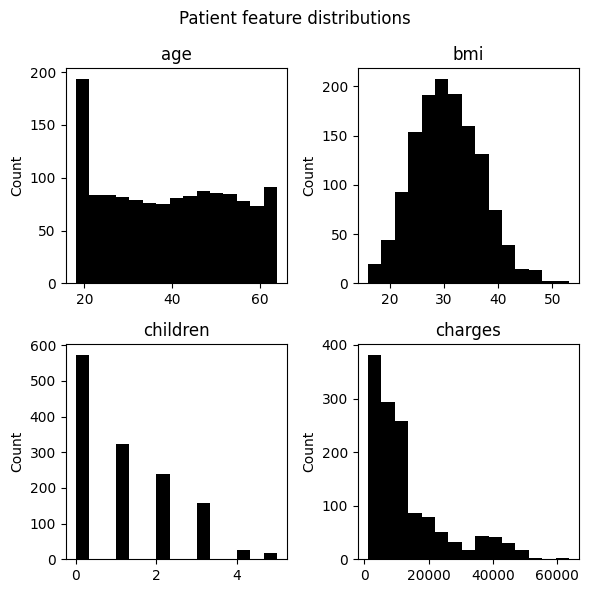

In [7]:
fig, axs = plt.subplots(2,2, figsize=(6,6))
axs = axs.flatten()

fig.suptitle('Patient feature distributions')

for i, feature in enumerate(interval_features):
    axs[i].set_title(feature)
    axs[i].hist(data_df[feature], color='black', bins=15)
    axs[i].set_ylabel('Count')

fig.tight_layout()
fig.show()

#### 2.1.2. Nominal features

In [8]:
nominal_features=['sex','smoker','region']
level_counts = funcs.get_level_counts(data_df, nominal_features)
level_counts.head(len(level_counts))

Count
feature level           
sex     male         676
        female       662
smoker  no          1064
        yes          274
region  southeast    364
        southwest    325
        northwest    325
        northeast    324

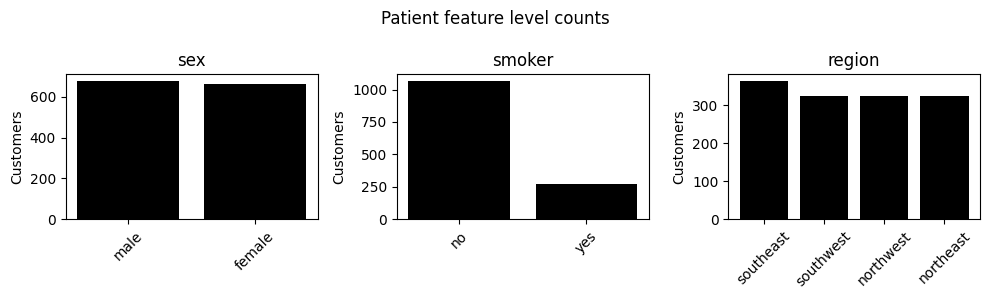

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.flatten()

fig.suptitle('Patient feature level counts')

for i, feature in enumerate(nominal_features):

    level_counts = data_df[feature].value_counts()

    axs[i].set_title(feature)
    axs[i].bar(list(range(len(level_counts))), level_counts, tick_label=level_counts.index, color='black')
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_ylabel('Customers')

fig.tight_layout()
fig.show()

### 2.2. Feature interactions

#### 2.2.1. Interval features vs label

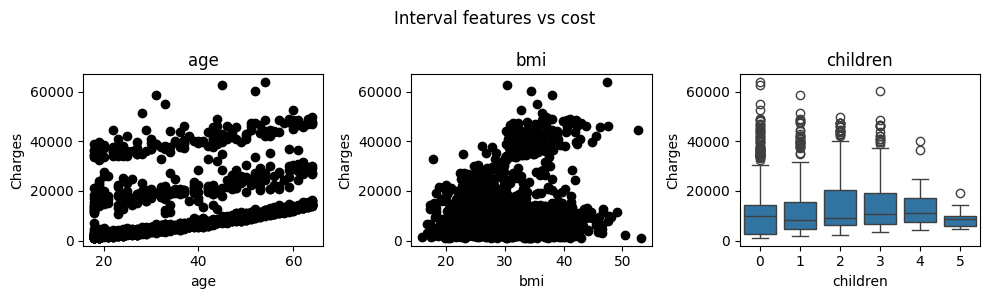

In [10]:
interval_features = ['age', 'bmi', 'children']

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.flatten()

fig.suptitle('Interval features vs cost')

for i, feature in enumerate(interval_features):

    level_counts = data_df[feature].value_counts()

    if feature != 'children':
        axs[i].set_title(feature)
        axs[i].scatter(data_df[feature], data_df['charges'], color='black')
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Charges')

    else:
        sns.boxplot(data=data_df, x=feature, y='charges', ax=axs[i])
        axs[i].set_title(feature)
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Charges')

fig.tight_layout()
fig.show()

#### 2.2.2. Nominal features vs label

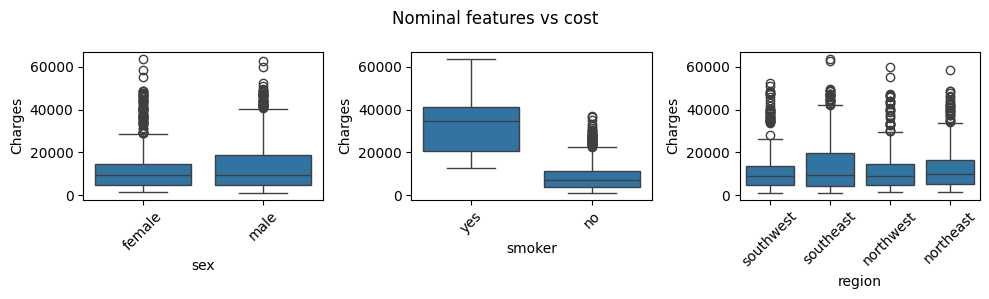

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs = axs.flatten()

fig.suptitle('Nominal features vs cost')

for i, feature in enumerate(nominal_features):

    sns.boxplot(data_df, x=feature, y='charges', ax=axs[i])
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Charges')

plt.tight_layout()
plt.show()

## 3. Data preparation

### 3.1. Train-test split

In [12]:
training_df, testing_df = train_test_split(
    data_df,
    test_size=0.2
)

### 3.2. Feature encoding

In [13]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(training_df[nominal_features])

training_df = funcs.encode_features(
    training_df,
    encoder,
    nominal_features
)

testing_df = funcs.encode_features(
    testing_df,
    encoder,
    nominal_features
)

training_df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1178,23,34.865,0,2899.48935,0.0,0.0,0.0,0.0,0.0
869,25,24.300,3,4391.65200,0.0,0.0,0.0,0.0,1.0
547,54,46.700,2,11538.42100,0.0,0.0,0.0,0.0,1.0
402,64,32.965,0,14692.66935,0.0,0.0,1.0,0.0,0.0
1297,28,26.510,2,4340.44090,0.0,0.0,0.0,1.0,0.0


## 4. Model training

In [14]:
results = {
    'RMSE': {},
    'R2': {}
}

### 4.1. Baseline

In [15]:
mean_cost = training_df['charges'].mean()
rmse = root_mean_squared_error(testing_df['charges'],[mean_cost]*len(testing_df))
rsq = r2_score(testing_df['charges'],[mean_cost]*len(testing_df))

results['RMSE']['Mean cost'] = rmse
results['R2']['Mean cost'] = rsq
print(f'Mean cost model RMSE: ${rmse:.2f}')
print(f'Mean cost model R squared: ${rsq:.2f}')

Mean cost model RMSE: $12699.41
Mean cost model R squared: $-0.00


In [16]:
linear_model = LinearRegression()
linear_model.fit(training_df.drop(columns=['charges']), training_df['charges'])

predictions = linear_model.predict(testing_df.drop(columns=['charges']))
rmse = root_mean_squared_error(testing_df['charges'], predictions)
rsq = r2_score(testing_df['charges'], predictions)

results['RMSE']['Regression'] = rmse
results['R2']['Regression'] = rsq
print(f'Testing data predictions RMSE: ${rmse:.2f}')
print(f'Testing data predictions R squared: {rsq:.2f}')

Testing data predictions RMSE: $6448.20
Testing data predictions R squared: 0.74


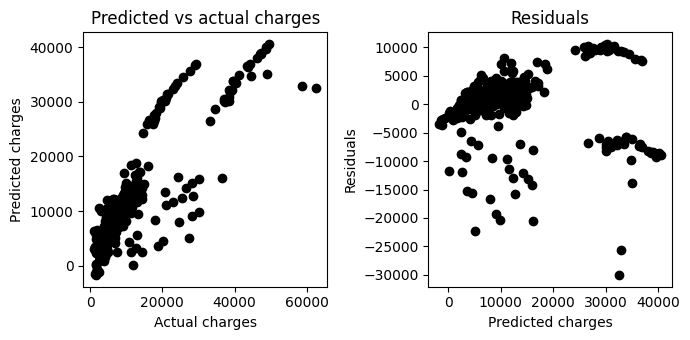

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
axs = axs.flatten()

axs[0].set_title('Predicted vs actual charges')
axs[0].scatter(testing_df['charges'], predictions, color='black')
axs[0].set_xlabel('Actual charges')
axs[0].set_ylabel('Predicted charges')

axs[1].set_title('Residuals')
axs[1].scatter(predictions, predictions - testing_df['charges'], color='black')
axs[1].set_xlabel('Predicted charges')
axs[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 4. Optimization

### 4.1. Feature transformations

In [18]:
scaled_training_df = training_df.copy()
scaled_testing_df = testing_df.copy()

feature_transformer = StandardScaler().fit(training_df.drop(columns=['charges']))
scaled_training_df[feature_transformer.feature_names_in_] = feature_transformer.transform(training_df[feature_transformer.feature_names_in_])
scaled_testing_df[feature_transformer.feature_names_in_] = feature_transformer.transform(testing_df[feature_transformer.feature_names_in_])

label_transformer = StandardScaler().fit(training_df['charges'].values.reshape(-1, 1))
scaled_training_df['charges'] = label_transformer.transform(training_df['charges'].values.reshape(-1, 1))
scaled_testing_df['charges'] = label_transformer.transform(testing_df['charges'].values.reshape(-1, 1))

training_df.describe()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,39.414019,30.560140,1.057944,13230.753655,0.512150,0.205607,0.245794,0.264486,0.246729
std,14.097668,5.966132,1.173614,11957.775534,0.500086,0.404334,0.430759,0.441265,0.431309
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,26.237500,0.000000,4763.252250,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,30.250000,1.000000,9502.441675,1.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,34.496250,2.000000,16584.318157,1.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000


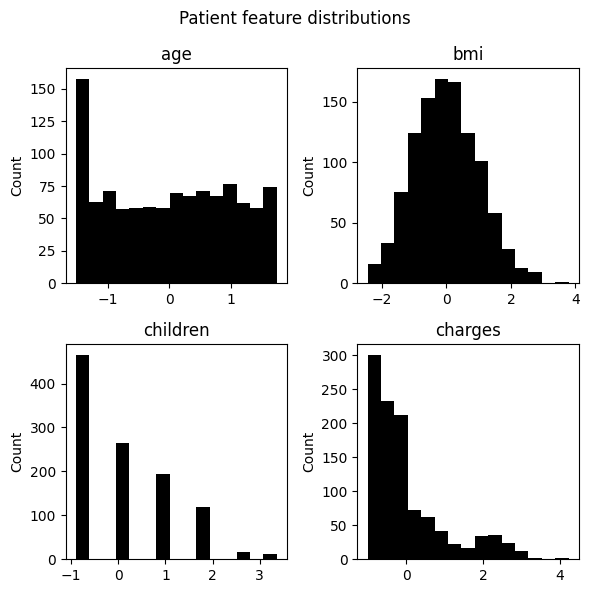

In [19]:
fig, axs = plt.subplots(2,2, figsize=(6,6))
axs = axs.flatten()

fig.suptitle('Patient feature distributions')

for i, feature in enumerate(['age', 'bmi', 'children', 'charges']):
    axs[i].set_title(feature)
    axs[i].hist(scaled_training_df[feature], color='black', bins=15)
    axs[i].set_ylabel('Count')

fig.tight_layout()
fig.show()

In [20]:
linear_model = LinearRegression()
linear_model.fit(scaled_training_df.drop(columns=['charges']), scaled_training_df['charges'])

predictions = linear_model.predict(scaled_testing_df.drop(columns=['charges']))
predictions = label_transformer.inverse_transform(predictions.reshape(-1, 1))
labels = label_transformer.inverse_transform(scaled_testing_df['charges'].values.reshape(-1, 1))
rmse = root_mean_squared_error(labels, predictions)
rsq = r2_score(labels, predictions)

results['RMSE']['Scaled regression'] = rmse
results['R2']['Scaled regression'] = rsq
print(f'Testing data predictions RMSE: ${rmse:.2f}')
print(f'Testing data predictions R squared: {rsq:.2f}')

Testing data predictions RMSE: $6448.20
Testing data predictions R squared: 0.74


### 4.2. Feature engineering

In [21]:
engineered_training_df = training_df.copy()
engineered_testing_df = testing_df.copy()

engineered_training_df['charges'] = engineered_training_df['charges'].clip(upper=50000)
engineered_training_df['age'] = engineered_training_df['age'] ** 2
engineered_training_df['children'] = 1 / (engineered_training_df['children'] + 1)

engineered_testing_df['charges'] = engineered_testing_df['charges'].clip(upper=50000)
engineered_testing_df['age'] = engineered_testing_df['age'] ** 2
engineered_testing_df['children'] = 1 / (engineered_testing_df['children'] + 1)

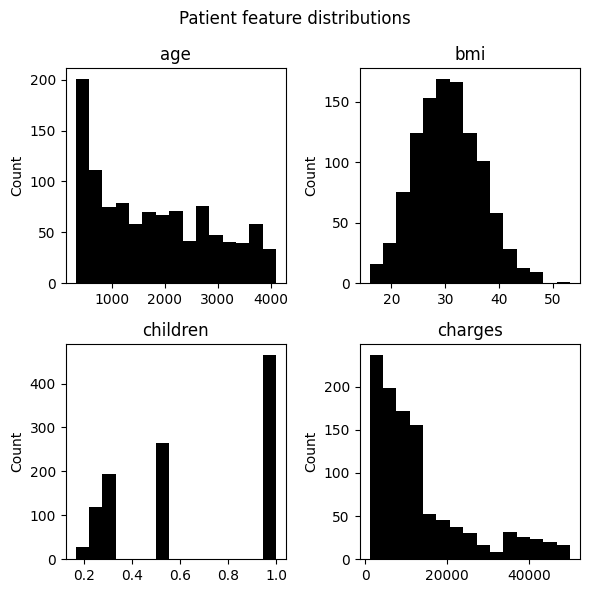

In [22]:
fig, axs = plt.subplots(2,2, figsize=(6,6))
axs = axs.flatten()

fig.suptitle('Patient feature distributions')

for i, feature in enumerate(['age', 'bmi', 'children', 'charges']):
    axs[i].set_title(feature)
    axs[i].hist(engineered_training_df[feature], color='black', bins=15)
    axs[i].set_ylabel('Count')

fig.tight_layout()
fig.show()

In [23]:
linear_model = LinearRegression()
linear_model.fit(engineered_training_df.drop(columns=['charges']), engineered_training_df['charges'])

predictions = linear_model.predict(engineered_testing_df.drop(columns=['charges']))
labels = engineered_testing_df['charges'].values.reshape(-1, 1)
rmse = root_mean_squared_error(labels, predictions)
rsq = r2_score(labels, predictions)

results['RMSE']['Engineered regression'] = rmse
results['R2']['Engineered regression'] = rsq
print(f'Testing data predictions RMSE: ${rmse:.2f}')
print(f'Testing data predictions R squared: {rsq:.2f}')

Testing data predictions RMSE: $6107.60
Testing data predictions R squared: 0.76


### 4.3. Synthetic features

In [24]:
poly_transformer = PolynomialFeatures(degree=4, include_bias=False)
poly_transformer.fit(engineered_training_df.drop(columns=['charges']))
poly_training_features = poly_transformer.transform(engineered_training_df.drop(columns=['charges']))
poly_testing_features = poly_transformer.transform(engineered_testing_df.drop(columns=['charges']))

poly_training_df = pd.DataFrame(poly_training_features, columns=poly_transformer.get_feature_names_out())
poly_testing_df = pd.DataFrame(poly_testing_features, columns=poly_transformer.get_feature_names_out())

poly_training_df['charges'] = engineered_training_df['charges'].values
poly_testing_df['charges'] = engineered_testing_df['charges'].values

poly_training_df.head().transpose()


,0,1,2,3,4
age,529.00000,625.000,2916.000000,4096.00000,784.000000
bmi,34.86500,24.300,46.700000,32.96500,26.510000
children,1.00000,0.250,0.333333,1.00000,0.333333
sex_male,0.00000,0.000,0.000000,0.00000,0.000000
smoker_yes,0.00000,0.000,0.000000,0.00000,0.000000
...,...,...,...,...,...
region_southeast^3 region_southwest,0.00000,0.000,0.000000,0.00000,0.000000
region_southeast^2 region_southwest^2,0.00000,0.000,0.000000,0.00000,0.000000
region_southeast region_southwest^3,0.00000,0.000,0.000000,0.00000,0.000000
region_southwest^4,0.00000,1.000,1.000000,0.00000,0.000000


In [25]:
linear_model = LinearRegression()
linear_model.fit(poly_training_df.drop(columns=['charges']), poly_training_df['charges'])

predictions = linear_model.predict(poly_testing_df.drop(columns=['charges']))
labels = poly_testing_df['charges'].values.reshape(-1, 1)
rmse = root_mean_squared_error(labels, predictions)
rsq = r2_score(labels, predictions)

results['RMSE']['Synthetic features regression'] = rmse
results['R2']['Synthetic features regression'] = rsq
print(f'Testing data predictions RMSE: ${rmse:.2f}')
print(f'Testing data predictions R squared: {rsq:.2f}')

Testing data predictions RMSE: $5234.26
Testing data predictions R squared: 0.82

Testing data predictions R squared: 0.82


### 4.4. Results

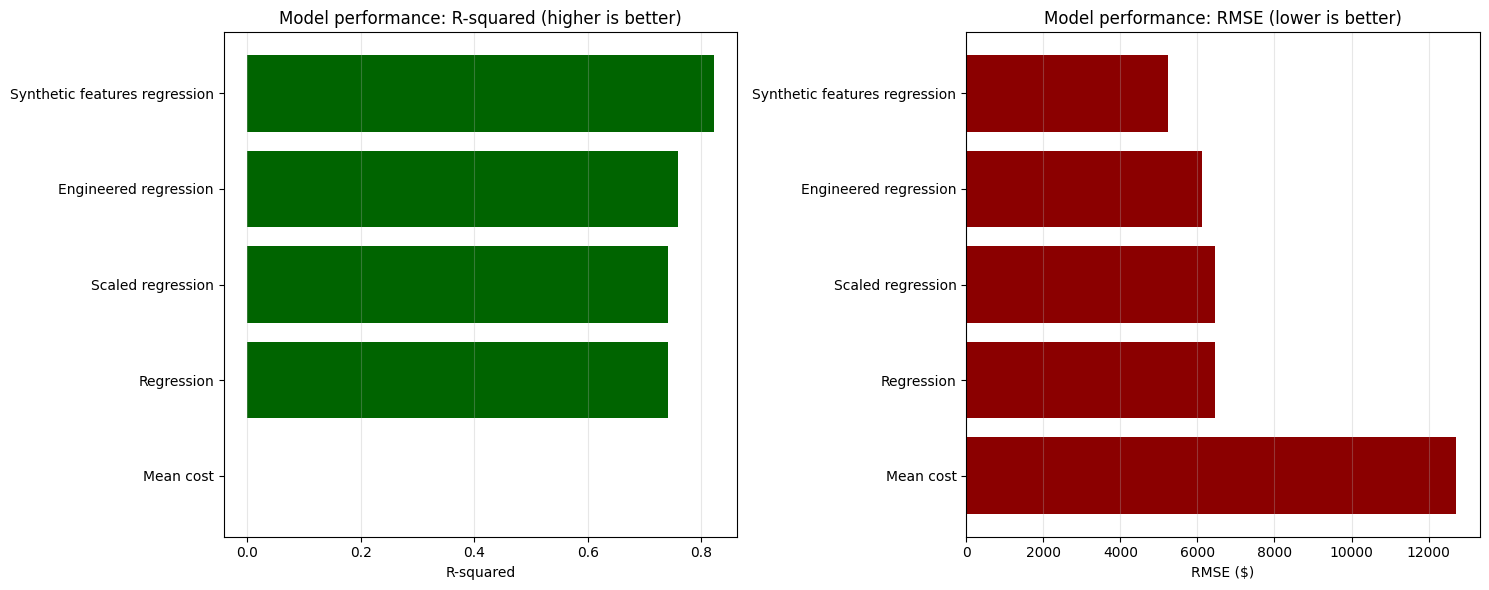

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# R-squared plot
axs[0].barh(list(results['R2'].keys()), list(results['R2'].values()), color='darkgreen')
axs[0].set_xlabel('R-squared')
axs[0].set_title('Model performance: R-squared (higher is better)')
axs[0].grid(axis='x', alpha=0.3)

# RMSE plot
axs[1].barh(list(results['RMSE'].keys()), list(results['RMSE'].values()), color='darkred')
axs[1].set_xlabel('RMSE ($)')
axs[1].set_title('Model performance: RMSE (lower is better)')
axs[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# Find the best model based on highest R-squared
best_model_name = max(results['R2'], key=results['R2'].get)
best_r2 = results['R2'][best_model_name]
best_rmse = results['RMSE'][best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"R-squared: {best_r2:.4f}")
print(f"RMSE: ${best_rmse:.2f}")

# Generate predictions for the best model
if best_model_name == 'Mean cost':
    best_predictions = [mean_cost] * len(testing_df)
    best_actual = testing_df['charges'].values
elif best_model_name == 'Regression':
    linear_model = LinearRegression()
    linear_model.fit(training_df.drop(columns=['charges']), training_df['charges'])
    best_predictions = linear_model.predict(testing_df.drop(columns=['charges']))
    best_actual = testing_df['charges'].values
elif best_model_name == 'Scaled regression':
    linear_model = LinearRegression()
    linear_model.fit(scaled_training_df.drop(columns=['charges']), scaled_training_df['charges'])
    predictions = linear_model.predict(scaled_testing_df.drop(columns=['charges']))
    best_predictions = label_transformer.inverse_transform(predictions.reshape(-1, 1)).flatten()
    best_actual = label_transformer.inverse_transform(scaled_testing_df['charges'].values.reshape(-1, 1)).flatten()
elif best_model_name == 'Engineered regression':
    linear_model = LinearRegression()
    linear_model.fit(engineered_training_df.drop(columns=['charges']), engineered_training_df['charges'])
    best_predictions = linear_model.predict(engineered_testing_df.drop(columns=['charges']))
    best_actual = engineered_testing_df['charges'].values
elif best_model_name == 'Synthetic features regression':
    linear_model = LinearRegression()
    linear_model.fit(poly_training_df.drop(columns=['charges']), poly_training_df['charges'])
    best_predictions = linear_model.predict(poly_testing_df.drop(columns=['charges']))
    best_actual = poly_testing_df['charges'].values
elif best_model_name == 'Split regression':
    split_model = SplitModel(poly_training_df, poly_testing_df)
    split_model.fit()
    split_model.predict()
    best_predictions = split_model.smoker_predictions.tolist() + split_model.nonsmoker_predictions.tolist()
    best_actual = split_model.smoker_testing_df['charges'].tolist() + split_model.nonsmoker_testing_df['charges'].tolist()

Best performing model: Synthetic features regression
R-squared: 0.8228
RMSE: $5234.26


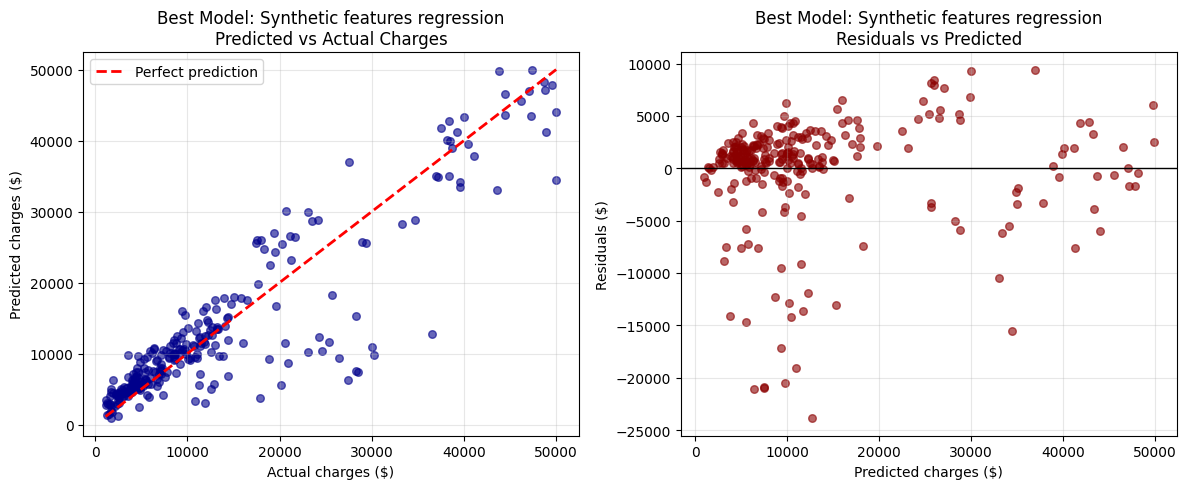


Best Model Performance Summary:
Model: Synthetic features regression
R-squared: 0.8228
RMSE: $5234.26
Mean Absolute Error: $3282.99
Residuals std: $5231.48


In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Predicted vs Actual plot
axs[0].scatter(best_actual, best_predictions, color='darkblue', alpha=0.6, s=30)
axs[0].plot([min(best_actual), max(best_actual)], [min(best_actual), max(best_actual)], 
            'r--', linewidth=2, label='Perfect prediction')
axs[0].set_xlabel('Actual charges ($)')
axs[0].set_ylabel('Predicted charges ($)')
axs[0].set_title(f'Best Model: {best_model_name}\nPredicted vs Actual Charges')
axs[0].legend()
axs[0].grid(alpha=0.3)

# Residuals plot
residuals = np.array(best_predictions) - np.array(best_actual)
axs[1].scatter(best_predictions, residuals, color='darkred', alpha=0.6, s=30)
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[1].set_xlabel('Predicted charges ($)')
axs[1].set_ylabel('Residuals ($)')
axs[1].set_title(f'Best Model: {best_model_name}\nResiduals vs Predicted')
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print some additional statistics
print(f"\nBest Model Performance Summary:")
print(f"Model: {best_model_name}")
print(f"R-squared: {best_r2:.4f}")
print(f"RMSE: ${best_rmse:.2f}")
print(f"Mean Absolute Error: ${np.mean(np.abs(residuals)):.2f}")
print(f"Residuals std: ${np.std(residuals):.2f}")